### environment
* non gpu
* tensorflow==2.2.0

# 1. import packages

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

# 2. load image for prediction

In [3]:
from PIL import Image

(726, 1210, 3)


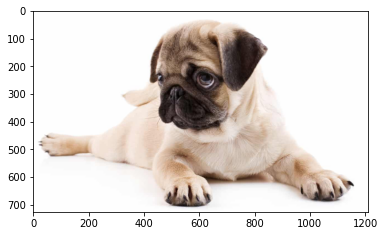

In [4]:
image_path = './test_image/1.jpg'
image_pil = Image.open(image_path)
predict_image = np.array(image_pil)
print(predict_image.shape)

plt.imshow(predict_image)
plt.show()

In [5]:
predict_image

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

# 3. load saved model & predict

### 1. load saved model

In [6]:
saved_model_path = './saved_model/'

In [7]:
loaded = tf.saved_model.load(saved_model_path)
print(list(loaded.signatures.keys()))

['serving_default']


In [8]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'Sigmoid': <tf.Tensor 'Sigmoid:0' shape=(None, None, None, 20) dtype=float32>, 'pose/locref_pred/block4/BiasAdd': <tf.Tensor 'pose/locref_pred/block4/BiasAdd:0' shape=(None, None, None, 40) dtype=float32>}


In [9]:
# labeling
bodyparts = [
    'Nose',
    'L_Eye',
    'R_Eye',
    'L_Ear',
    'R_Ear',
    'Throat',
    'Withers',
    'TailSet',
    'L_F_Paw',
    'R_F_Paw',
    'L_F_Wrist',
    'R_F_Wrist',
    'L_F_Elbow',
    'R_F_Elbow',
    'L_B_Paw',
    'R_B_Paw',
    'L_B_Hock',
    'R_B_Hock',
    'L_B_Stiffle',
    'R_B_Stiffle'
]

### 2. predict

In [10]:
%%time
preds = infer(tf.constant(predict_image, dtype=tf.float32))

CPU times: user 6.09 s, sys: 939 ms, total: 7.03 s
Wall time: 1.07 s


In [11]:
result = []
result.append(preds['Sigmoid'].numpy())
result.append(preds['pose/locref_pred/block4/BiasAdd'].numpy())
result

[array([[[[1.4208371e-05, 2.0966834e-05, 7.3486467e-06, ...,
           1.8488137e-05, 1.5889798e-05, 1.5687478e-05],
          [1.5147676e-06, 5.7857449e-07, 6.1464715e-07, ...,
           1.6764167e-06, 1.5017774e-06, 9.1212064e-07],
          [5.9065860e-07, 1.1090084e-07, 1.9692328e-07, ...,
           7.4469472e-07, 9.7256361e-07, 2.8477226e-07],
          ...,
          [2.2576785e-05, 4.7124768e-06, 2.5667246e-06, ...,
           1.8740015e-05, 7.7458126e-06, 6.7497449e-06],
          [8.9853074e-06, 1.4369898e-06, 8.3258487e-07, ...,
           4.7593444e-06, 4.2011243e-06, 2.8354261e-06],
          [1.6119782e-05, 4.4875560e-06, 2.0197335e-06, ...,
           2.4489276e-05, 9.9725657e-06, 9.1793545e-06]],
 
         [[4.3285769e-07, 4.8502869e-07, 1.6624628e-07, ...,
           5.0301276e-07, 9.6912026e-07, 1.0462372e-06],
          [5.4265882e-08, 2.2811246e-08, 1.6715953e-08, ...,
           4.3177479e-08, 2.7449607e-07, 8.6146237e-08],
          [6.5420420e-09, 1.9368620e-0

### 3. define function for pose extraction
refer function of deeplabcut

In [12]:
def extract_cnn_output(outputs_np, locref_stdev):
    scmap = np.squeeze(outputs_np[0])
    locref = np.squeeze(outputs_np[1])
    shape = locref.shape
    locref = np.reshape(locref, (shape[0], shape[1], -1, 2))
    locref *= locref_stdev
    
    return scmap, locref

In [13]:
def get_top_values(scmap):
    batchsize, ny, nx, num_joints = scmap.shape
    scmap_flat = scmap.reshape(batchsize, nx * ny, num_joints)
    scmap_top = np.argmax(scmap_flat, axis=1)[None]
    Y, X = np.unravel_index(scmap_top, (ny, nx))
    return Y, X

In [14]:
def multi_pose_predict(scmap, locref, stride):
    Y, X = get_top_values(scmap[None])
    Y, X = Y[:, 0], X[:, 0]
    num_joints = scmap.shape[2]
    DZ = np.zeros((1, num_joints, 3))
    for k in range(num_joints):
        x = X[0, k]
        y = Y[0, k]
        DZ[0, k, :2] = locref[y, x, k, :]
        DZ[0, k, 2] = scmap[y, x, k]

    X = X.astype("float32") * stride + 0.5 * stride + DZ[:, :, 0]
    Y = Y.astype("float32") * stride + 0.5 * stride + DZ[:, :, 1]
    P = DZ[:, :, 2]
    
    pose = np.empty((num_joints, 3), dtype="float32")
    pose[:, 0::3] = X.T
    pose[:, 1::3] = Y.T
    pose[:, 2::3] = P.T

    return pose

### 4. pose extraction

In [15]:
locref_stdef = 7.2801
stride = 8.0

In [16]:
scmap, locref = extract_cnn_output(result, locref_stdef)
pose = multi_pose_predict(scmap, locref, stride)
pose.shape

(20, 3)

In [17]:
# print '[x coordinate, y coordinate, likelihood], bodyparts'
for index in range(len(bodyparts)):
    print(pose[index], bodyparts[index])

[519.04553    300.76486      0.94436324] Nose
[623.0466    247.82462     0.9954307] L_Eye
[459.8442    243.91832     0.9960531] R_Eye
[770.198     129.0636      0.8274023] L_Ear
[439.67017  163.8385     0.631763] R_Ear
[597.50464   468.98615     0.7492074] Throat
[379.85797    349.85864      0.58668464] Withers
[8.4027478e+02 1.3914766e+02 1.4771929e-01] TailSet
[1.1059996e+03 6.3272705e+02 8.0982375e-01] L_F_Paw
[ 66.82626   480.10666     0.6555599] R_F_Paw
[9.8341205e+02 5.6771979e+02 3.8547581e-01] L_F_Wrist
[5.3770746e+02 5.7334650e+02 3.7163597e-01] R_F_Wrist
[7.2140680e+02 5.6222235e+02 2.7363801e-01] L_F_Elbow
[4.4882629e+02 5.4807660e+02 2.8873038e-01] R_F_Elbow
[3.30136383e+02 5.46545898e+02 1.12029254e-01] L_B_Paw
[3.2985501e+02 5.4718555e+02 2.2773913e-01] R_B_Paw
[7.2379013e+01 5.1681683e+02 1.1064857e-02] L_B_Hock
[3.2303650e+02 5.2894867e+02 3.6934078e-02] R_B_Hock
[9.215022e+02 5.612724e+02 5.082825e-02] L_B_Stiffle
[2.9613336e+02 5.0239584e+02 2.0901194e-01] R_B_Stiffle

### 5. draw pose on image

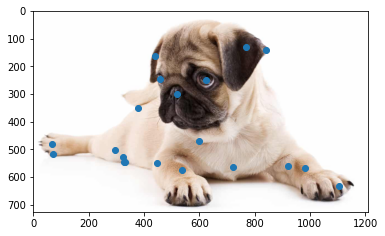

In [18]:
plt.imshow(predict_image)

plt_x = pose[:, 0]
plt_y = pose[:, 1]
plt.scatter(plt_x, plt_y)

plt.show()